[View in Colaboratory](https://colab.research.google.com/github/evergou/TitanicML/blob/master/Processing_&_Modeling.ipynb)

# Processing the data

In [0]:
!git clone https://github.com/pair-code/facets.git

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from IPython.display import display, HTML
from sklearn.metrics import recall_score, roc_auc_score, precision_score, accuracy_score, confusion_matrix, classification_report
pd.set_option("display.max_colwidth",100)
%matplotlib inline

In [0]:
train = pd.read_csv(r"Data/train.csv", index_col = 0)
test = pd.read_csv(r"Data/test.csv", index_col = 0)

In [0]:
train.Cabin.fillna(0,inplace=True)
test.Cabin.fillna(0,inplace=True)
train["CabinCode"] = train.Cabin.apply(lambda x: str(x)[0])
test["CabinCode"] = test.Cabin.apply(lambda x: str(x)[0])

In [0]:
train.Age.fillna(train.Age.mean(),inplace=True)
train.Embarked.fillna(train.Embarked.mode()[0],inplace=True)
train["Sex"],a = train.Sex.factorize()
del(a)

In [0]:
train = train.join(train.groupby("Ticket").Survived.sum()>1, how="left", on="Ticket", rsuffix="_in_the_party")

In [0]:
#Display the Dive visualization for the training data.
from IPython.core.display import display, HTML

jsonstr = test.to_json(orient='records')
HTML_TEMPLATE = """<link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))

In [0]:
train = pd.concat([train, pd.get_dummies(train["Embarked"], prefix="embark_")],1).drop(["Name","Ticket","Cabin","Embarked"],1)

In [0]:
train = pd.concat([train, pd.get_dummies(train["CabinCode"], prefix="cabin_")],1).drop("CabinCode",1)

In [0]:
#scaling the data
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
x_scaled = StandardScaler().fit_transform(train.drop("Survived",1))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, train.Survived, test_size=0.3, stratify = train.Survived)

In [0]:
# Add the path to the feature stats generation code.
#import sys
#sys.path.insert(0, '/content/facets/facets_overview/python/')

# Create the feature stats for the datasets and stringify it.
import base64
from generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': train},
                                  {'name': 'test', 'table': test}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

In [0]:
# Display the facets overview visualization for this data
from IPython.core.display import display, HTML

HTML_TEMPLATE = """<link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

# LightGBM

In [0]:
!pip install lightgbm

In [0]:
import lightgbm as lgb
evals_result = {}
param = {'num_leaves':3, 'num_trees':12000, 'objective':'binary', "boosting":"dart",
         "learning_rate":0.001, "max_depth":3, "max_bin":50, "min_data_in_leaf":5,         
         "tree_learner":"feature", "verbose":1, "drop_rate":0.1, "xgboost_dart_mode": True, "predict_raw_score":True,
         "sigmoid" :1}
param['metric'] = 'auc'
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, y_test, reference=train_data)

In [0]:
bst = lgb.train(param, train_data, evals_result = evals_result, verbose_eval = 1000,
               valid_sets = [train_data, test_data])

In [0]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()

print('Feature importances:', list(bst.feature_importance()))

In [0]:
prediction = bst.predict(X_test, num_iteration=bst.best_iteration)

In [0]:
pred = np.zeros(len(prediction))
pred[prediction>0.4]=1

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred)

# Other Models

In [0]:
from __future__ import print_function
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

SEED= 44
def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED, warm_start= "True")
    nn = MLPClassifier((10,10,10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    sgdb = SGDClassifier(loss="log")    
    bagging = BaggingClassifier(gb)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)
    ada = AdaBoostClassifier(base_estimator = gb, n_estimators = 50)
    models = {
             'knn': knn,
             'naive bayes': nb,
             "svc": svc,
             'mlp-nn': nn,
             'random forest': rf,
             'gbm': gb,
             "bag" : bagging,
             "sgdb" : sgdb,
             'logistic': lr,
             'ada': ada              
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ")
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict(X_test)
        #[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = accuracy_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")
    

In [0]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

# DNN

In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['acc']), 
           label='Train Accuracy')
  plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val Accuracy')
  plt.legend()
  plt.ylim([0.6,0.950])

In [0]:
rate = 0.1

model = keras.Sequential([keras.layers.Dense(10, input_dim = X_train.shape[1], activation=tf.nn.relu),
                          keras.layers.Dropout(rate, noise_shape=None, seed=None),
                          keras.layers.Dense(10, activation=tf.nn.relu),
                          keras.layers.Dropout(rate, noise_shape=None, seed=None),
                          keras.layers.Dense(10, activation=tf.nn.relu),
                          keras.layers.Dropout(rate, noise_shape=None, seed=None),
                          keras.layers.Dense(10, activation=tf.nn.relu),
                          keras.layers.Dropout(rate, noise_shape=None, seed=None),
                          keras.layers.Dense(10, activation=tf.nn.relu),
                          keras.layers.Dropout(rate, noise_shape=None, seed=None),
                          keras.layers.Dense(10, activation=tf.nn.relu),
                          keras.layers.Dropout(rate, noise_shape=None, seed=None),
                          keras.layers.Dense(1, activation="sigmoid")    
])
#model.summary()

In [0]:
model.compile(optimizer= tf.train.GradientDescentOptimizer(learning_rate = 0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [0]:
history = model.fit(X_train, y_train, epochs=2000, verbose=1, validation_split=0.2,shuffle=1)

Train on 498 samples, validate on 125 samples
Epoch 1/2000
498/498 [==============================] - 1s 1ms/step - loss: 0.6880 - acc: 0.5582 - val_loss: 0.6878 - val_acc: 0.6160
Epoch 2/2000
498/498 [==============================] - 0s 205us/step - loss: 0.6888 - acc: 0.5281 - val_loss: 0.6876 - val_acc: 0.6880
Epoch 3/2000
498/498 [==============================] - 0s 230us/step - loss: 0.6921 - acc: 0.5823 - val_loss: 0.6873 - val_acc: 0.7040
Epoch 4/2000
498/498 [==============================] - 0s 201us/step - loss: 0.6899 - acc: 0.6145 - val_loss: 0.6870 - val_acc: 0.7040
Epoch 5/2000
498/498 [==============================] - 0s 190us/step - loss: 0.6872 - acc: 0.6285 - val_loss: 0.6868 - val_acc: 0.6800
Epoch 6/2000
498/498 [==============================] - 0s 190us/step - loss: 0.6878 - acc: 0.6205 - val_loss: 0.6865 - val_acc: 0.6800
Epoch 7/2000
498/498 [==============================] - 0s 196us/step - loss: 0.6884 - acc: 0.6104 - val_loss: 0.6863 - val_acc: 0.6800
Epoc

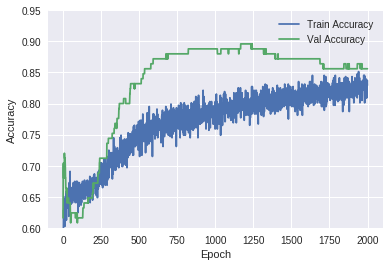

In [0]:
plot_history(history)